# Nhận diện biển báo giao thông

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Activation
from tensorflow.keras.models import Model
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

## Prepare Dataset

In [2]:
data_dir = 'D:/HUS_22001541/PPNCKH/TrafficSign_Recognition/input'
train_path = 'D:/HUS_22001541/PPNCKH/TrafficSign_Recognition/input/Train'
test_path = 'D:/HUS_22001541/PPNCKH/TrafficSign_Recognition/input/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [3]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [ ]:
# Label 
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Visualizing Dataset

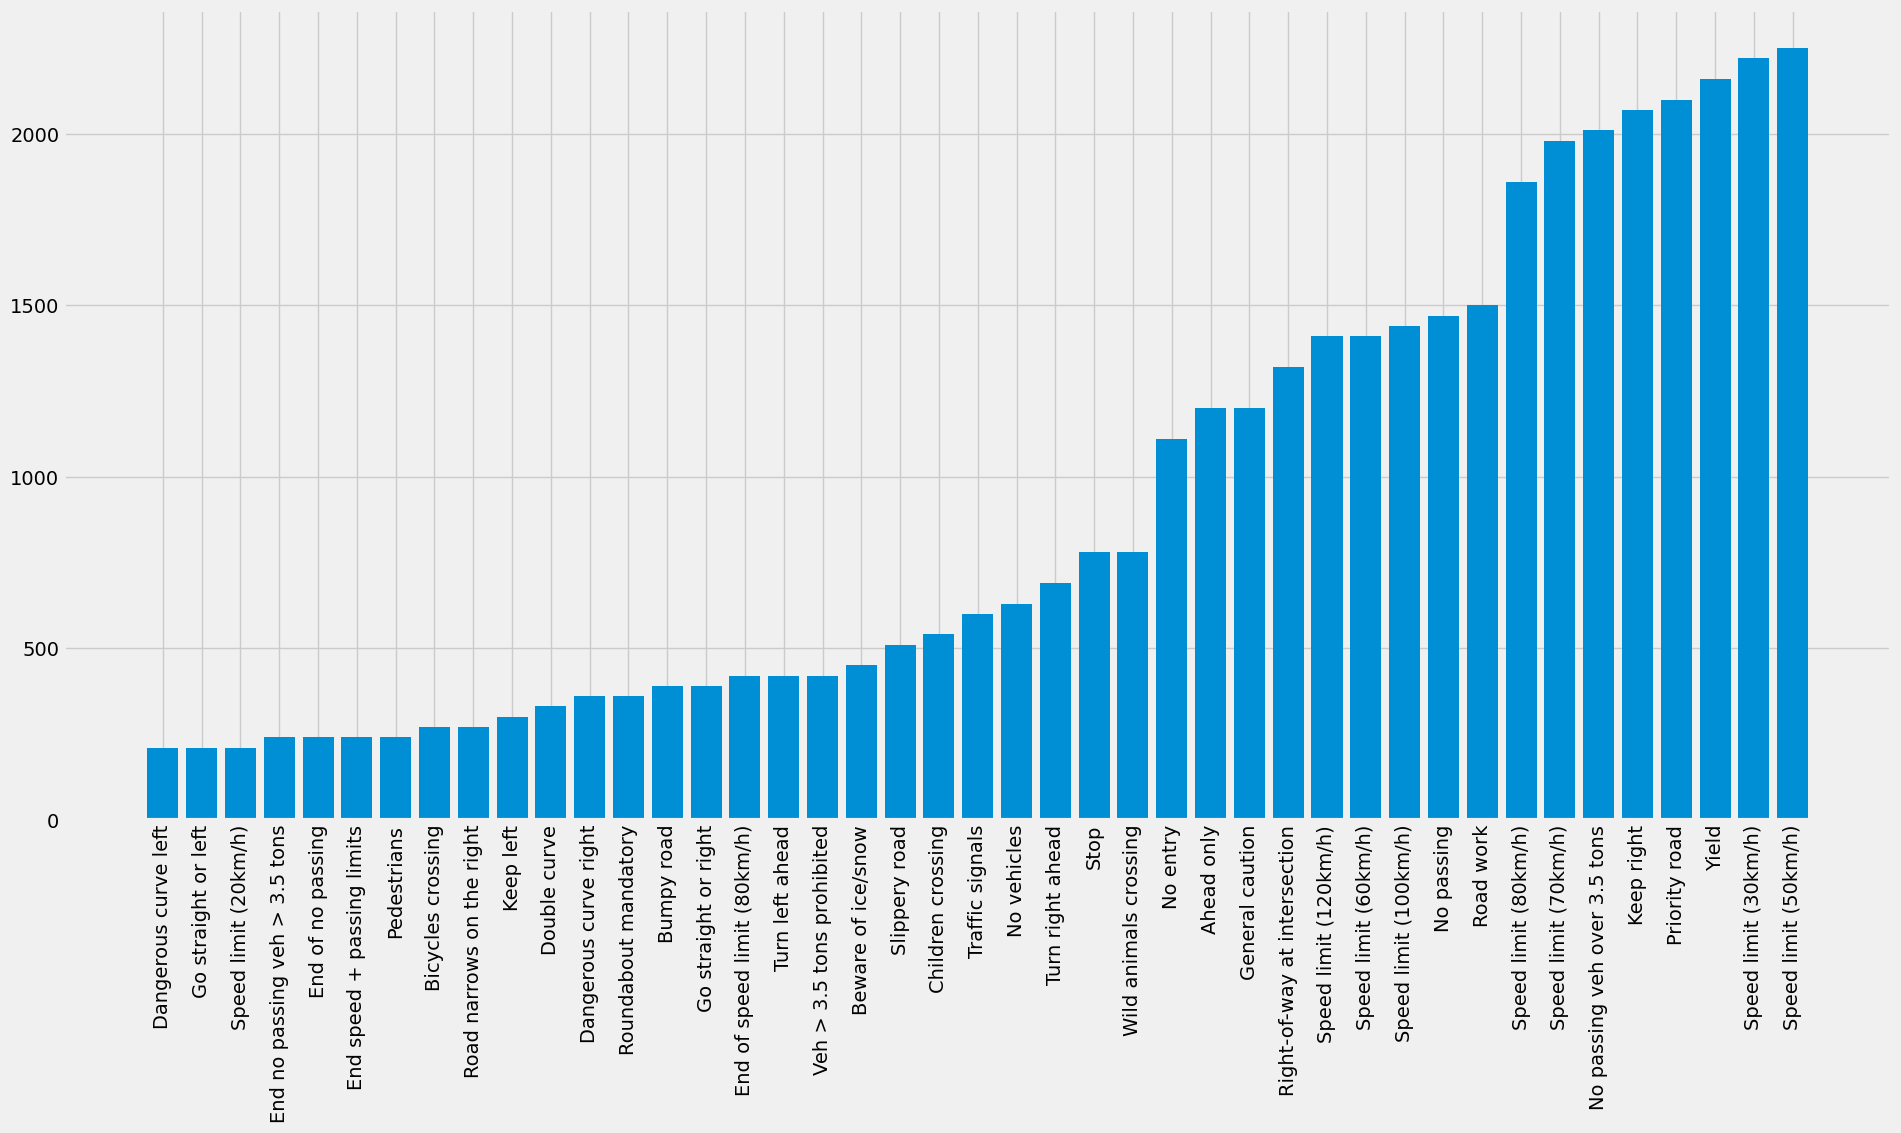

In [5]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

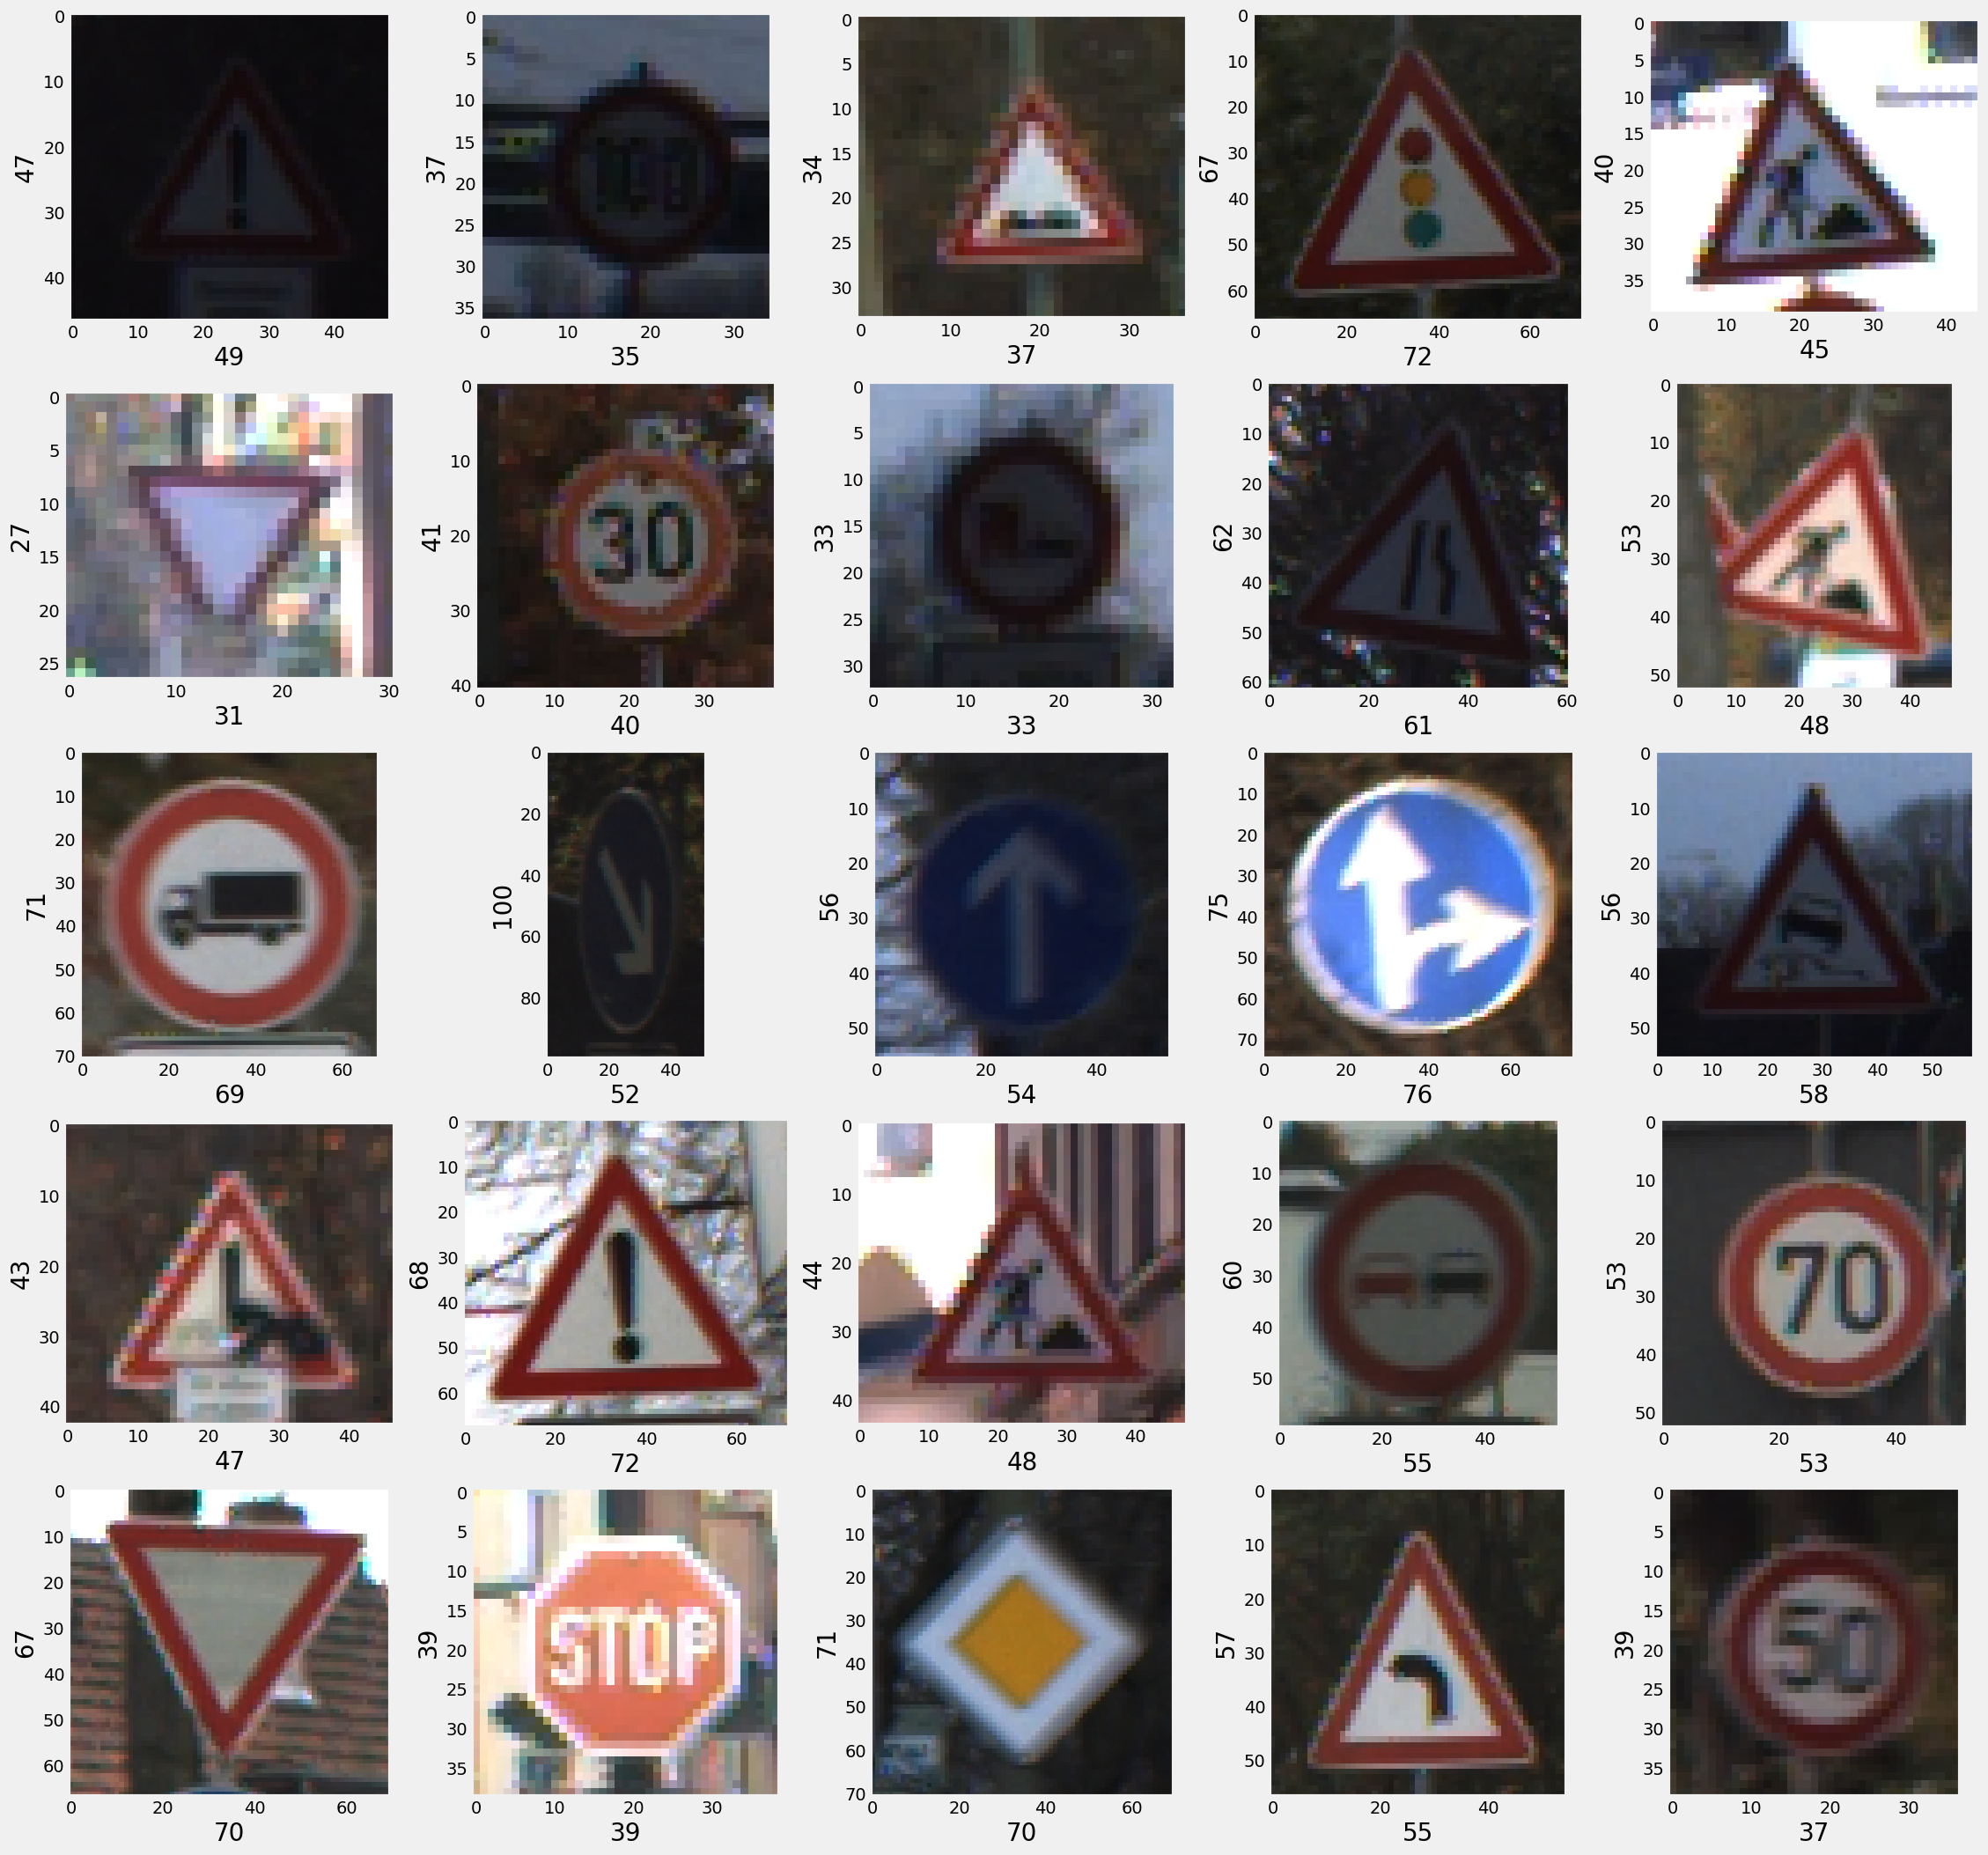

In [6]:
# Visualizing 25 random images
import random
from matplotlib.image import imread
import matplotlib.pyplot as plt
import pandas as pd

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1, 26):
    plt.subplot(5, 5, i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(visible=None) 
    plt.xlabel(rand_img.shape[1], fontsize=20)  
    plt.ylabel(rand_img.shape[0], fontsize=20)  

plt.show()  

## Train Data

In [7]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Shuffring

In [8]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [9]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## One hot encoding the labels

In [10]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## Making the model

In [ ]:
input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, channels))

# Block 1
conv1 = Conv2D(filters=16, kernel_size=(3,3))(input)
conv1 = Activation('relu')(conv1)
conv2 = Conv2D(filters=32, kernel_size=(3,3))(conv1)
conv2 = Activation('relu')(conv2)
pool1 = MaxPooling2D(pool_size=(2,2))(conv2)
bn1 = BatchNormalization(axis=-1)(pool1)

# Block 2
conv3 = Conv2D(filters=64, kernel_size=(3,3))(bn1)
conv3 = Activation('relu')(conv3)
conv4 = Conv2D(filters=128, kernel_size=(3,3))(conv3)
conv4 = Activation('relu')(conv4)
pool2 = MaxPooling2D(pool_size=(2,2))(conv4)
bn2 = BatchNormalization(axis=-1)(pool2)

# Fully connected layers
flatten = Flatten()(bn2)
dense1 = Dense(512)(flatten)
dense1 = Activation('relu')(dense1)
bn3 = BatchNormalization()(dense1)
drop1 = Dropout(rate=0.5)(bn3)

# Output layer
output = Dense(43, activation='softmax')(drop1)

# Tạo model
model = Model(inputs=input, outputs=output)

In [12]:
lr = 0.001
epochs = 30

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

c:\Users\Admin\anaconda3\envs\py310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Augmenting data & training the model

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Cấu hình ImageDataGenerator để tăng cường dữ liệu
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

# Định nghĩa checkpoint để lưu mô hình tốt nhất
fle_s = 'traffic_sign_model_trained_final.h5'
checkpointer = ModelCheckpoint(
    filepath=fle_s,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'
)

# Danh sách callback
callback_list = [checkpointer]

# Huấn luyện mô hình với ImageDataGenerator
history = model.fit(
    aug.flow(X_train, y_train, batch_size=32),
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callback_list
)


Epoch 1/30
853/858 [============================>.] - ETA: 0s - loss: 1.1880 - accuracy: 0.6790
Epoch 1: loss improved from inf to 1.18275, saving model to traffic_sign_model_trained_final.h5
858/858 [==============================] - 19s 12ms/step - loss: 1.1828 - accuracy: 0.6803 - val_loss: 0.0931 - val_accuracy: 0.9726
Epoch 2/30
856/858 [============================>.] - ETA: 0s - loss: 0.1906 - accuracy: 0.9424
Epoch 2: loss improved from 1.18275 to 0.19027, saving model to traffic_sign_model_trained_final.h5
858/858 [==============================] - 8s 9ms/step - loss: 0.1903 - accuracy: 0.9425 - val_loss: 0.0457 - val_accuracy: 0.9860
Epoch 3/30
852/858 [============================>.] - ETA: 0s - loss: 0.1103 - accuracy: 0.9657
Epoch 3: loss improved from 0.19027 to 0.11040, saving model to traffic_sign_model_trained_final.h5
858/858 [==============================] - 8s 9ms/step - loss: 0.1104 - accuracy: 0.9656 - val_loss: 0.0294 - val_accuracy: 0.9916
Epoch 4/30
852/858 [=

In [14]:
# aug = ImageDataGenerator(
#     rotation_range=10,
#     zoom_range=0.15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.15,
#     horizontal_flip=False,
#     vertical_flip=False,
#     fill_mode="nearest")

# history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

In [15]:
# # Lưu mô hình vào file .h5
# model.save('trafficsign_model_pretrained.h5')
# print("Mô hình đã được lưu thành công vào file 'trafficsign_model_pretrained.h5'")

In [16]:
# model.save("traffic_sign_model_trained.h5", include_optimizer=True)

## Evaluating the model

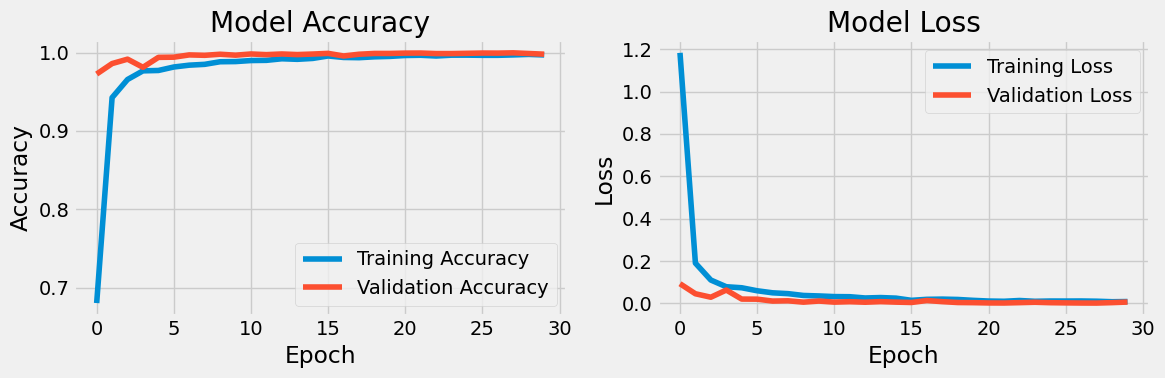

In [17]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ accuracy
plt.figure(figsize=(12, 4))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Loading the test data and running the predictions

In [18]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 2s 3ms/step
Test Data accuracy:  98.43230403800474


## Classification report

In [19]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      0.99       720
           2       0.99      0.99      0.99       750
           3       0.98      0.98      0.98       450
           4       1.00      0.99      0.99       660
           5       0.98      1.00      0.99       630
           6       1.00      1.00      1.00       150
           7       0.99      1.00      0.99       450
           8       1.00      0.99      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.95      0.98      0.97       420
          12       1.00      0.99      0.99       690
          13       0.99      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       1.00      0.98      0.99       210
          16       1.00      1.00      1.00       150
          17       1.00    

## Predictions on Test Data

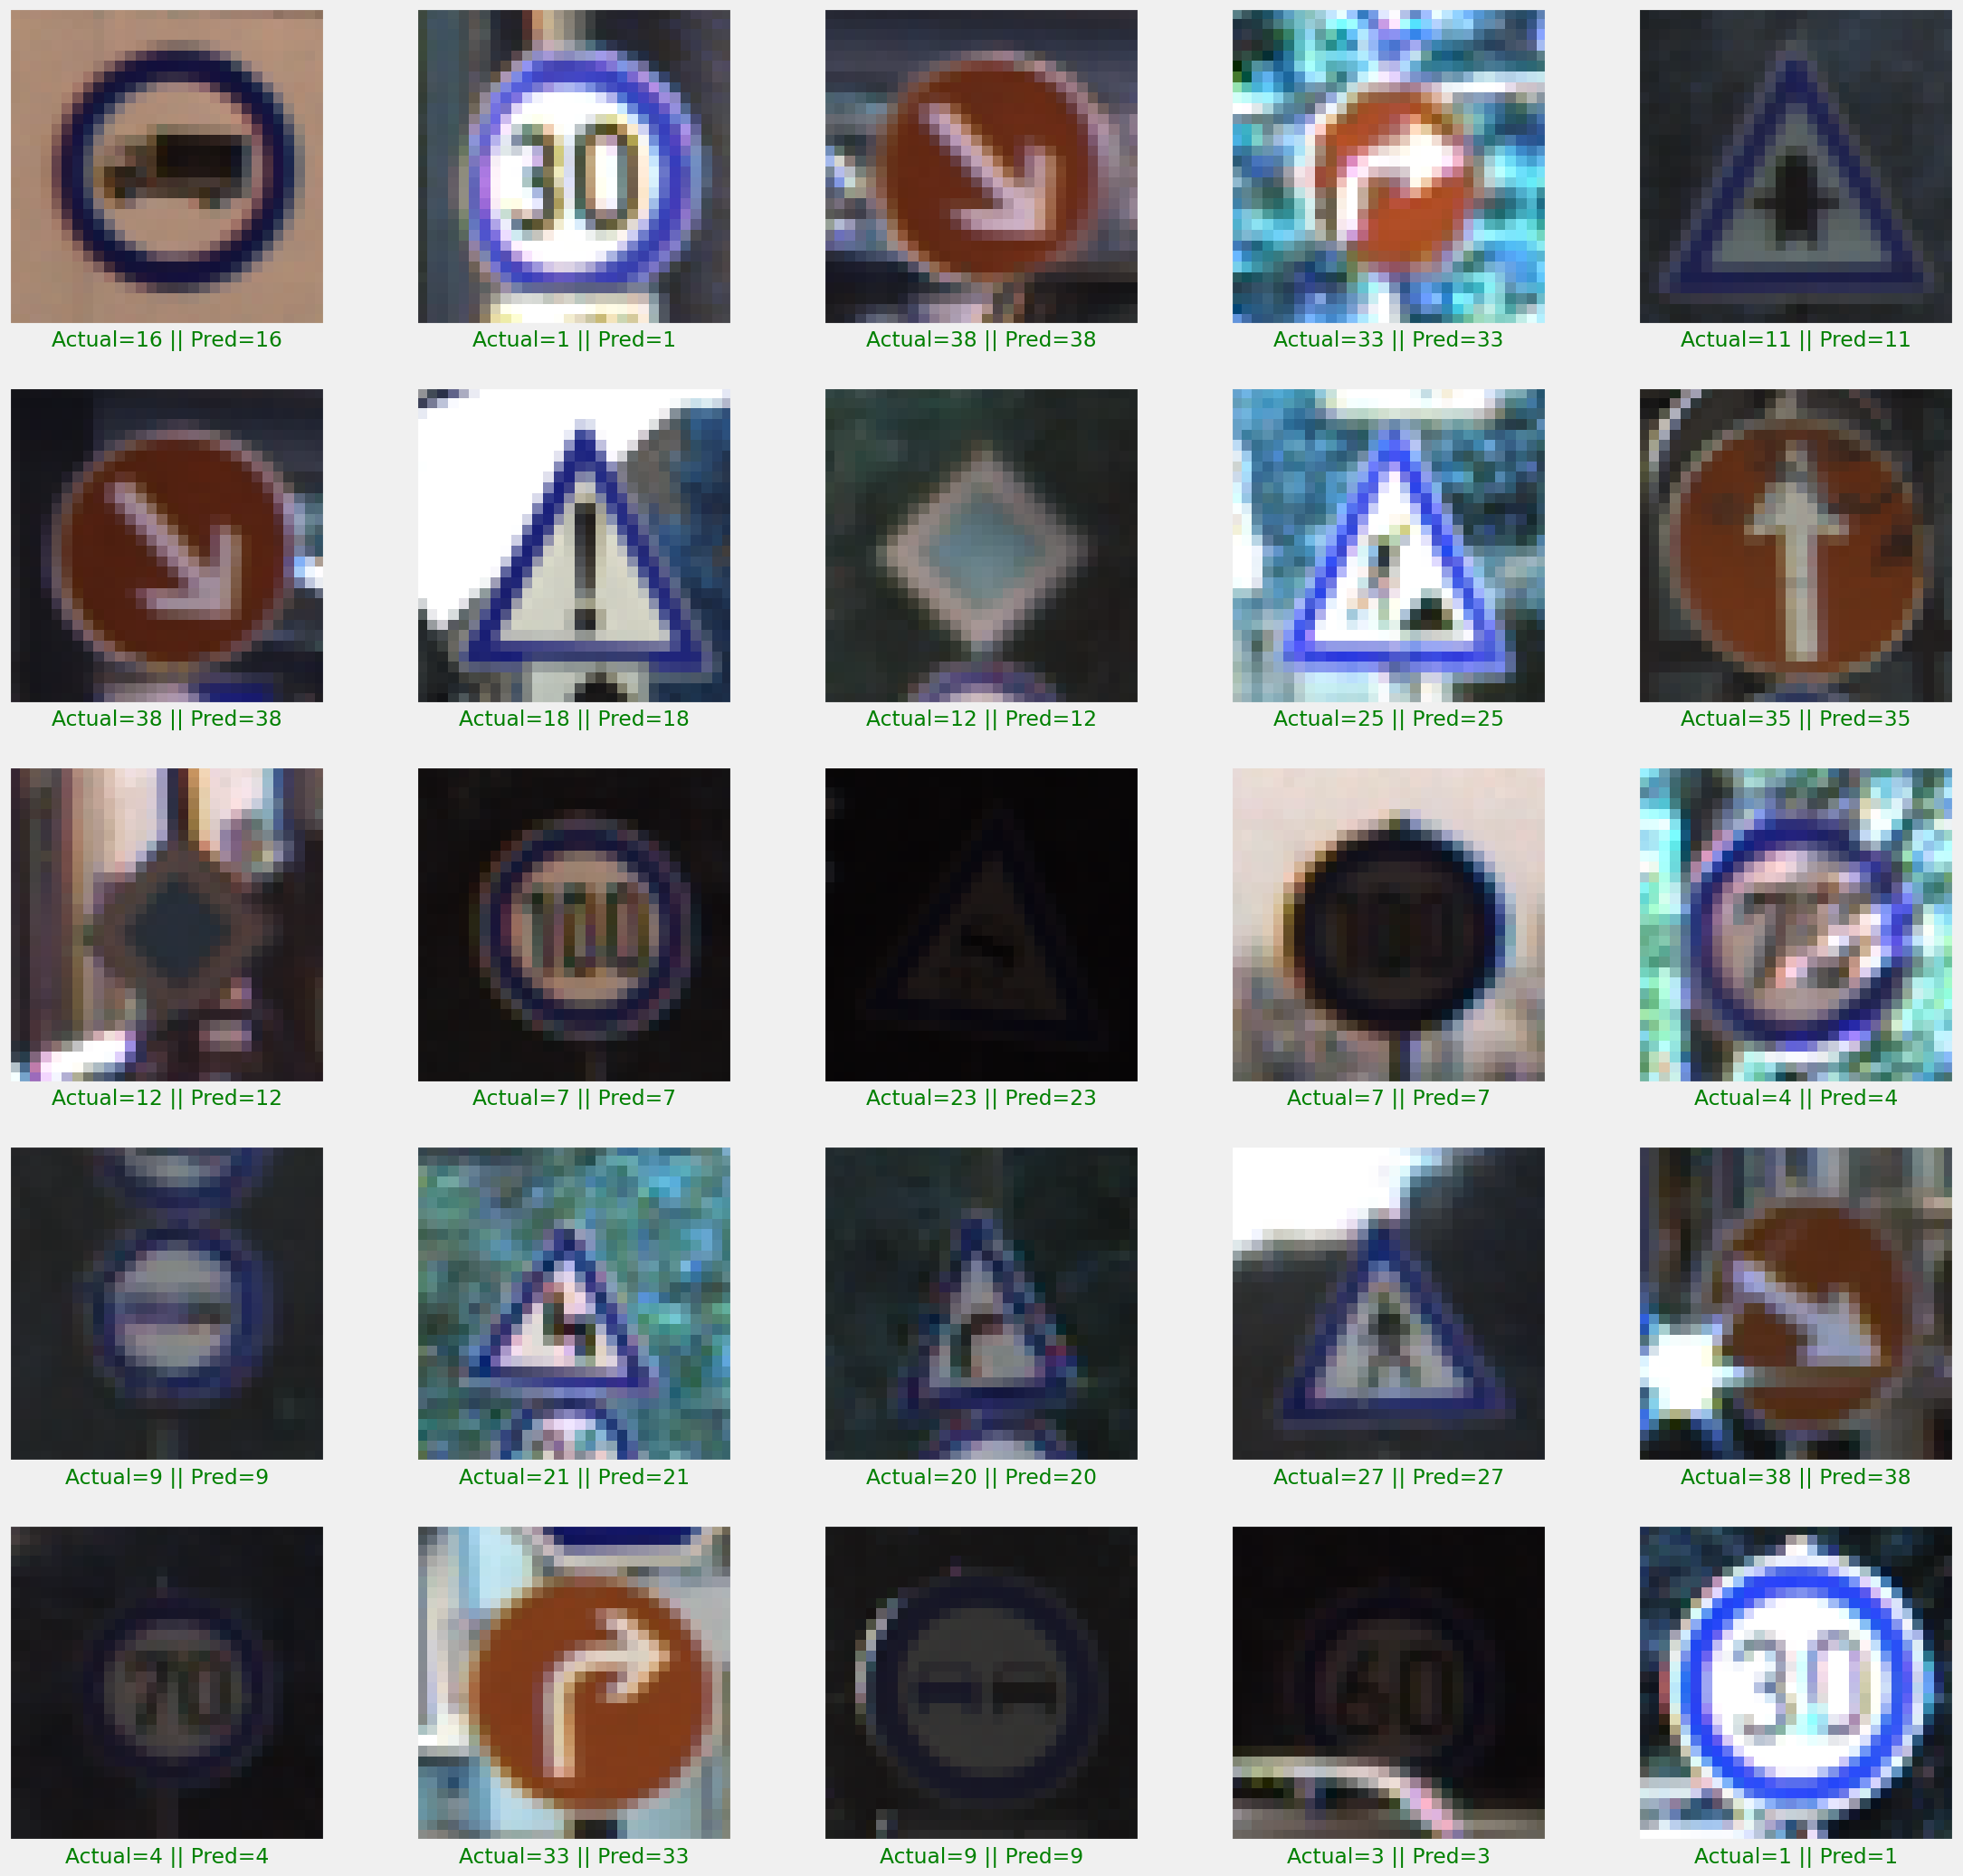

In [20]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()